In [63]:
import numpy as np
import cv2
import os
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#  Loading Data

In [74]:
models_accuracy=[]
def calculate_accuracy(y_test,y_pred):
    count = 0
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            count+=1
    return count/len(y_test)

In [3]:
dataset = "dataset/"
num_classes = len(os.listdir(dataset))
img_height,img_width,channels = 64,64,3

In [4]:
names = list(os.listdir(dataset))

In [5]:
datamap=[]
for sub_dir_path in glob.glob(dataset+"*"):
    dirname = sub_dir_path.split("/")[-1]
    for filename in os.listdir(sub_dir_path):
        image_path = sub_dir_path + "/" + filename
        datamap.extend([dirname, image_path])

df = pd.DataFrame({"dirname" : datamap[::2],
                  "path" : datamap[1::2]})
df.head()

dirname                                               path
0  Anthracnose   dataset/Anthracnose/20211011_165842 (Custom).jpg
1  Anthracnose  dataset/Anthracnose/IMG_20211011_140309 (Custo...
2  Anthracnose  dataset/Anthracnose/20211011_171141 - Copy - C...
3  Anthracnose   dataset/Anthracnose/20211011_170708 (Custom).jpg
4  Anthracnose  dataset/Anthracnose/IMG_20211011_153447 (Custo...

In [6]:
X = np.zeros((len(df.path),64,64,3),dtype=np.uint8)
Y = []
print("X shape",X.shape)

X shape (4000, 64, 64, 3)


In [7]:
for n,id_ in tqdm(enumerate(df.path),total=len(df.path)):
    img = cv2.imread(id_)
    img = cv2.resize(img,(64,64))
    X[n] = img
    Y.append(id_.split("/")[1])

100%|█████████████████████████████████████| 4000/4000 [00:03<00:00, 1321.82it/s]


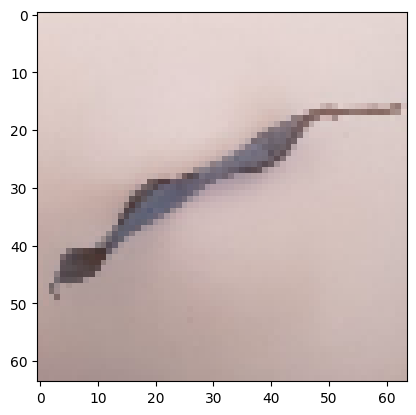

In [8]:
plt.imshow(X[random.randint(0,len(X))])

# Encoding

In [9]:
le = LabelEncoder()
labels = le.fit_transform(Y)
labels = to_categorical(labels)
labels = np.array(labels)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

# Ploting images randomly

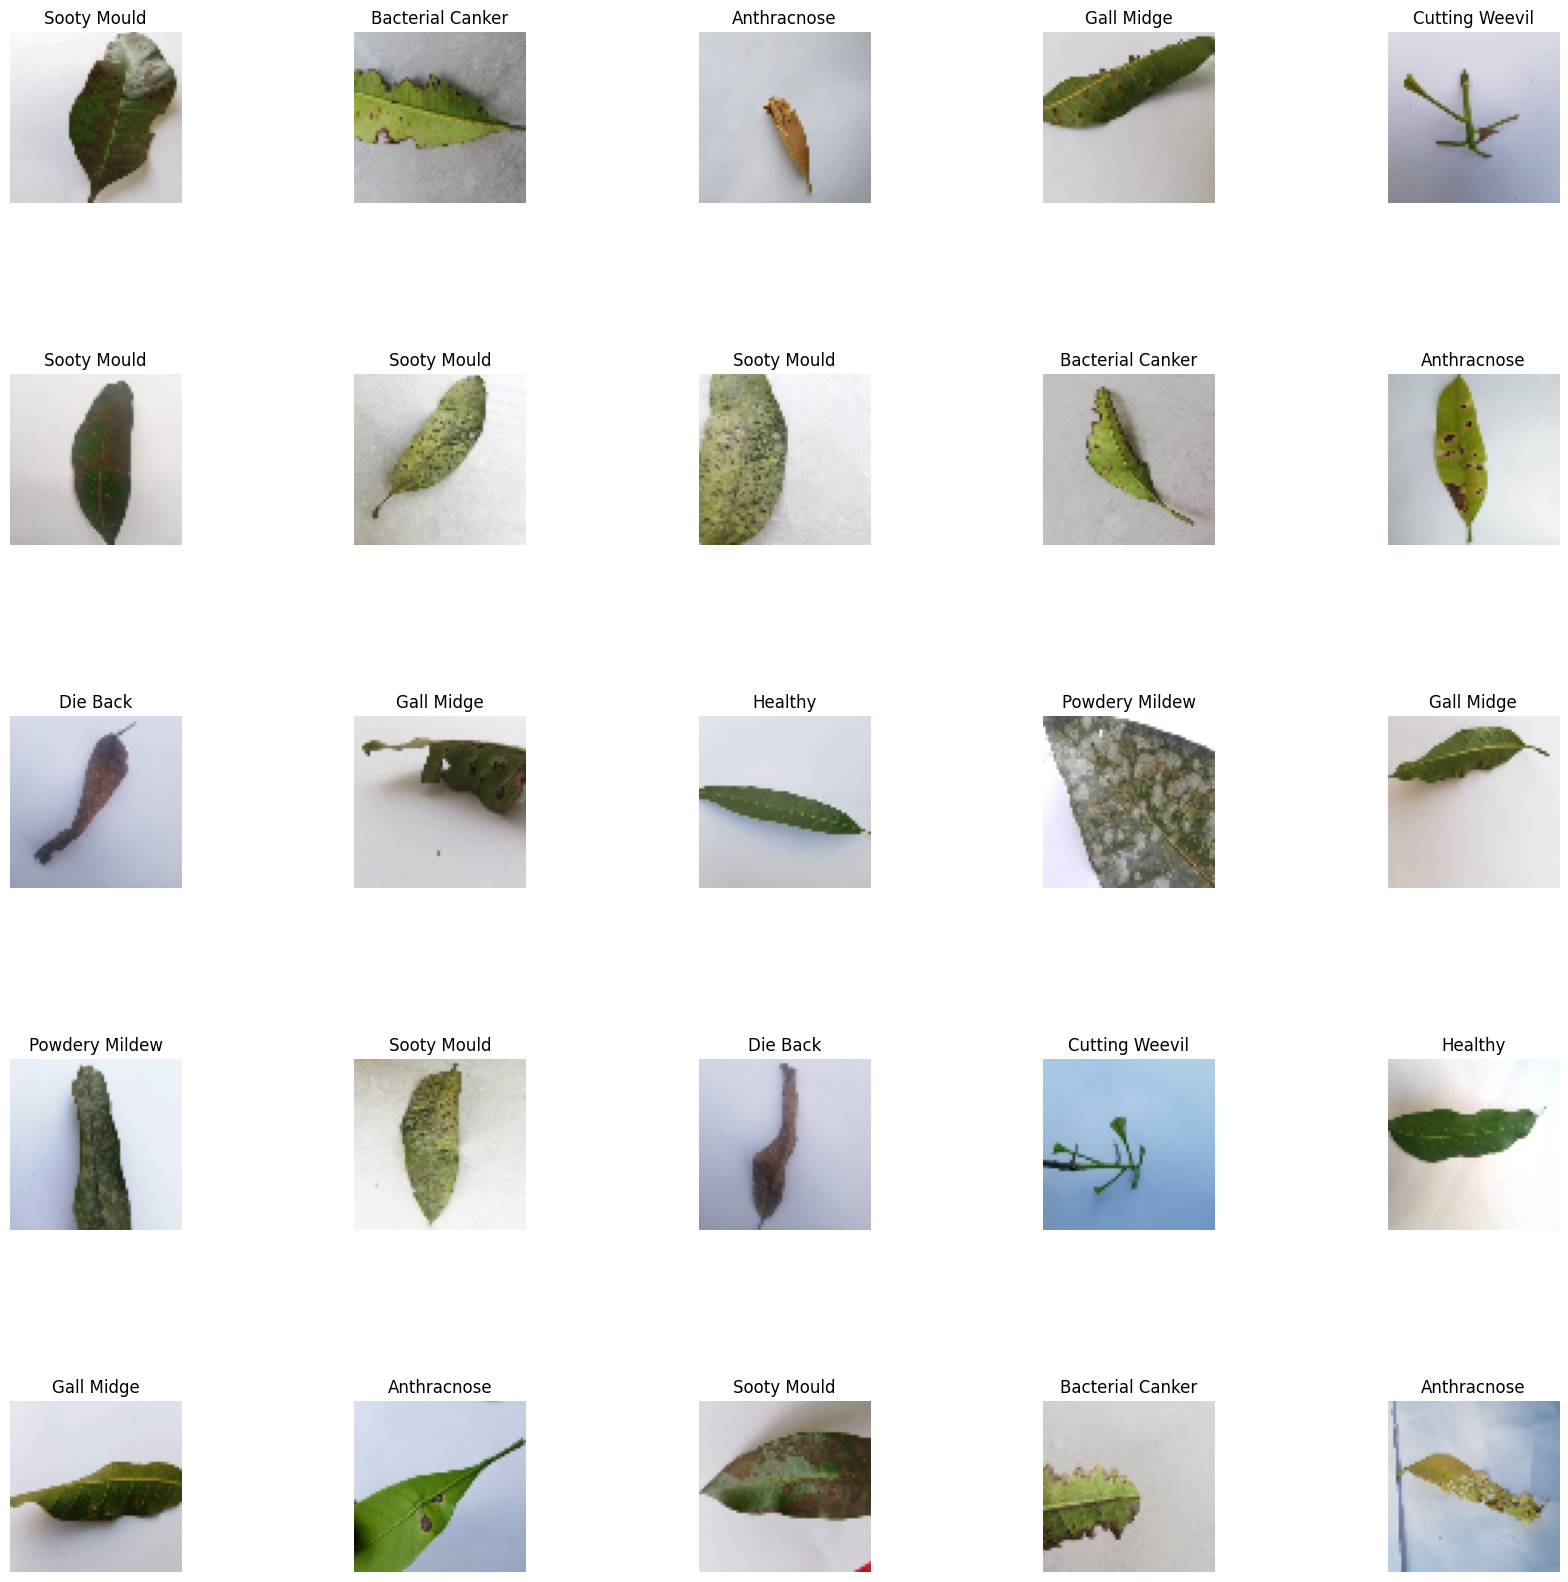

In [10]:
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(20,20))
axes = axes.ravel()
for i in range(5*5):
    number = random.randint(0,len(X))
    axes[i].imshow(cv2.cvtColor(X[number],cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'{Y[number]}')
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)   

In [11]:
x_train,x_test,y_train,y_test = train_test_split(X,labels,test_size=0.4)
val_x, test_x, val_y,test_y = train_test_split(x_test,y_test,test_size=0.5)

# Model 1

In [12]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',kernel_initializer = 'he_normal',padding = 'same',input_shape = (64,64,3)))
model.add(Conv2D(32,(3,3),activation = 'relu',kernel_initializer = 'he_normal',padding = 'same',input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))

model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))

model.add(Dense(num_classes,activation='softmax',kernel_initializer='he_normal'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       73984     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 256)       5

2023-04-30 19:29:52.641050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-30 19:29:52.686968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-30 19:29:52.687254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-30 19:29:52.688215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [13]:
model_checkpoint = ModelCheckpoint("model1.h5",monitor="val_loss",mode = "min",save_best_only=True,verbose=1)
early_Stopping = EarlyStopping(monitor="val_loss",min_delta=0,patience=8,restore_best_weights=True,verbose=1)
callbacks = [model_checkpoint,early_Stopping]

In [14]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])
history = model.fit(x_train,y_train,epochs=20,validation_data=(val_x,val_y),callbacks=callbacks)

Epoch 1/20


2023-04-30 19:29:55.852590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-04-30 19:29:56.838334: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-30 19:29:57.151785: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 19:29:57.152895: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 19:29:57.393006: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate

75/75 [==============================] - ETA: 0s - loss: 2.2273 - accuracy: 0.3679
Epoch 1: val_loss improved from inf to 35.80580, saving model to model1.h5
75/75 [==============================] - 14s 85ms/step - loss: 2.2273 - accuracy: 0.3679 - val_loss: 35.8058 - val_accuracy: 0.1538
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 1.1188 - accuracy: 0.5908
Epoch 2: val_loss improved from 35.80580 to 5.50828, saving model to model1.h5
75/75 [==============================] - 6s 85ms/step - loss: 1.1188 - accuracy: 0.5908 - val_loss: 5.5083 - val_accuracy: 0.1637
Epoch 3/20
75/75 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.7375
Epoch 3: val_loss improved from 5.50828 to 2.07184, saving model to model1.h5
75/75 [==============================] - 6s 87ms/step - loss: 0.7403 - accuracy: 0.7375 - val_loss: 2.0718 - val_accuracy: 0.4688
Epoch 4/20
75/75 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.8012
Epoch 4: va

In [15]:
log_model1 = history.history

Text(0.5, 1.0, 'Loss vs Validation Loss')

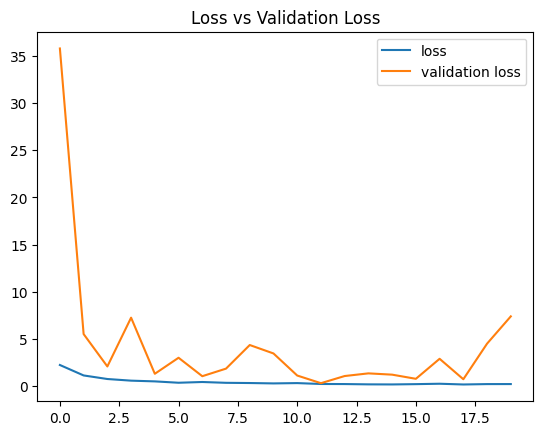

In [16]:
plt.plot(log_model1["loss"],label = "loss")
plt.plot(log_model1["val_loss"],label="validation loss")
plt.legend()
plt.title("Loss vs Validation Loss")

Text(0.5, 1.0, 'Accuracy vs Validation accuracy')

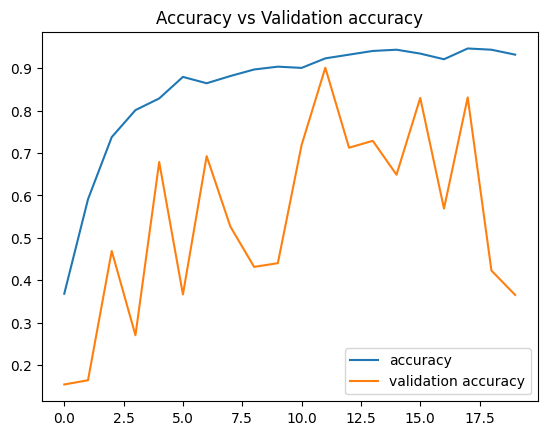

In [17]:
plt.plot(log_model1["accuracy"],label = "accuracy")
plt.plot(log_model1["val_accuracy"],label="validation accuracy")
plt.legend()
plt.title("Accuracy vs Validation accuracy")

In [18]:
y_pred = model.predict(test_x)
y_pred_1 = [0]*len(y_pred)
test_y_1 = [0]*len(y_pred)
for n,i in enumerate(zip(y_pred,test_y)):
    y_pred_1[n] = np.argmax(y_pred[n])
    test_y_1[n] = np.argmax(test_y[n])

25/25 [==============================] - 1s 19ms/step


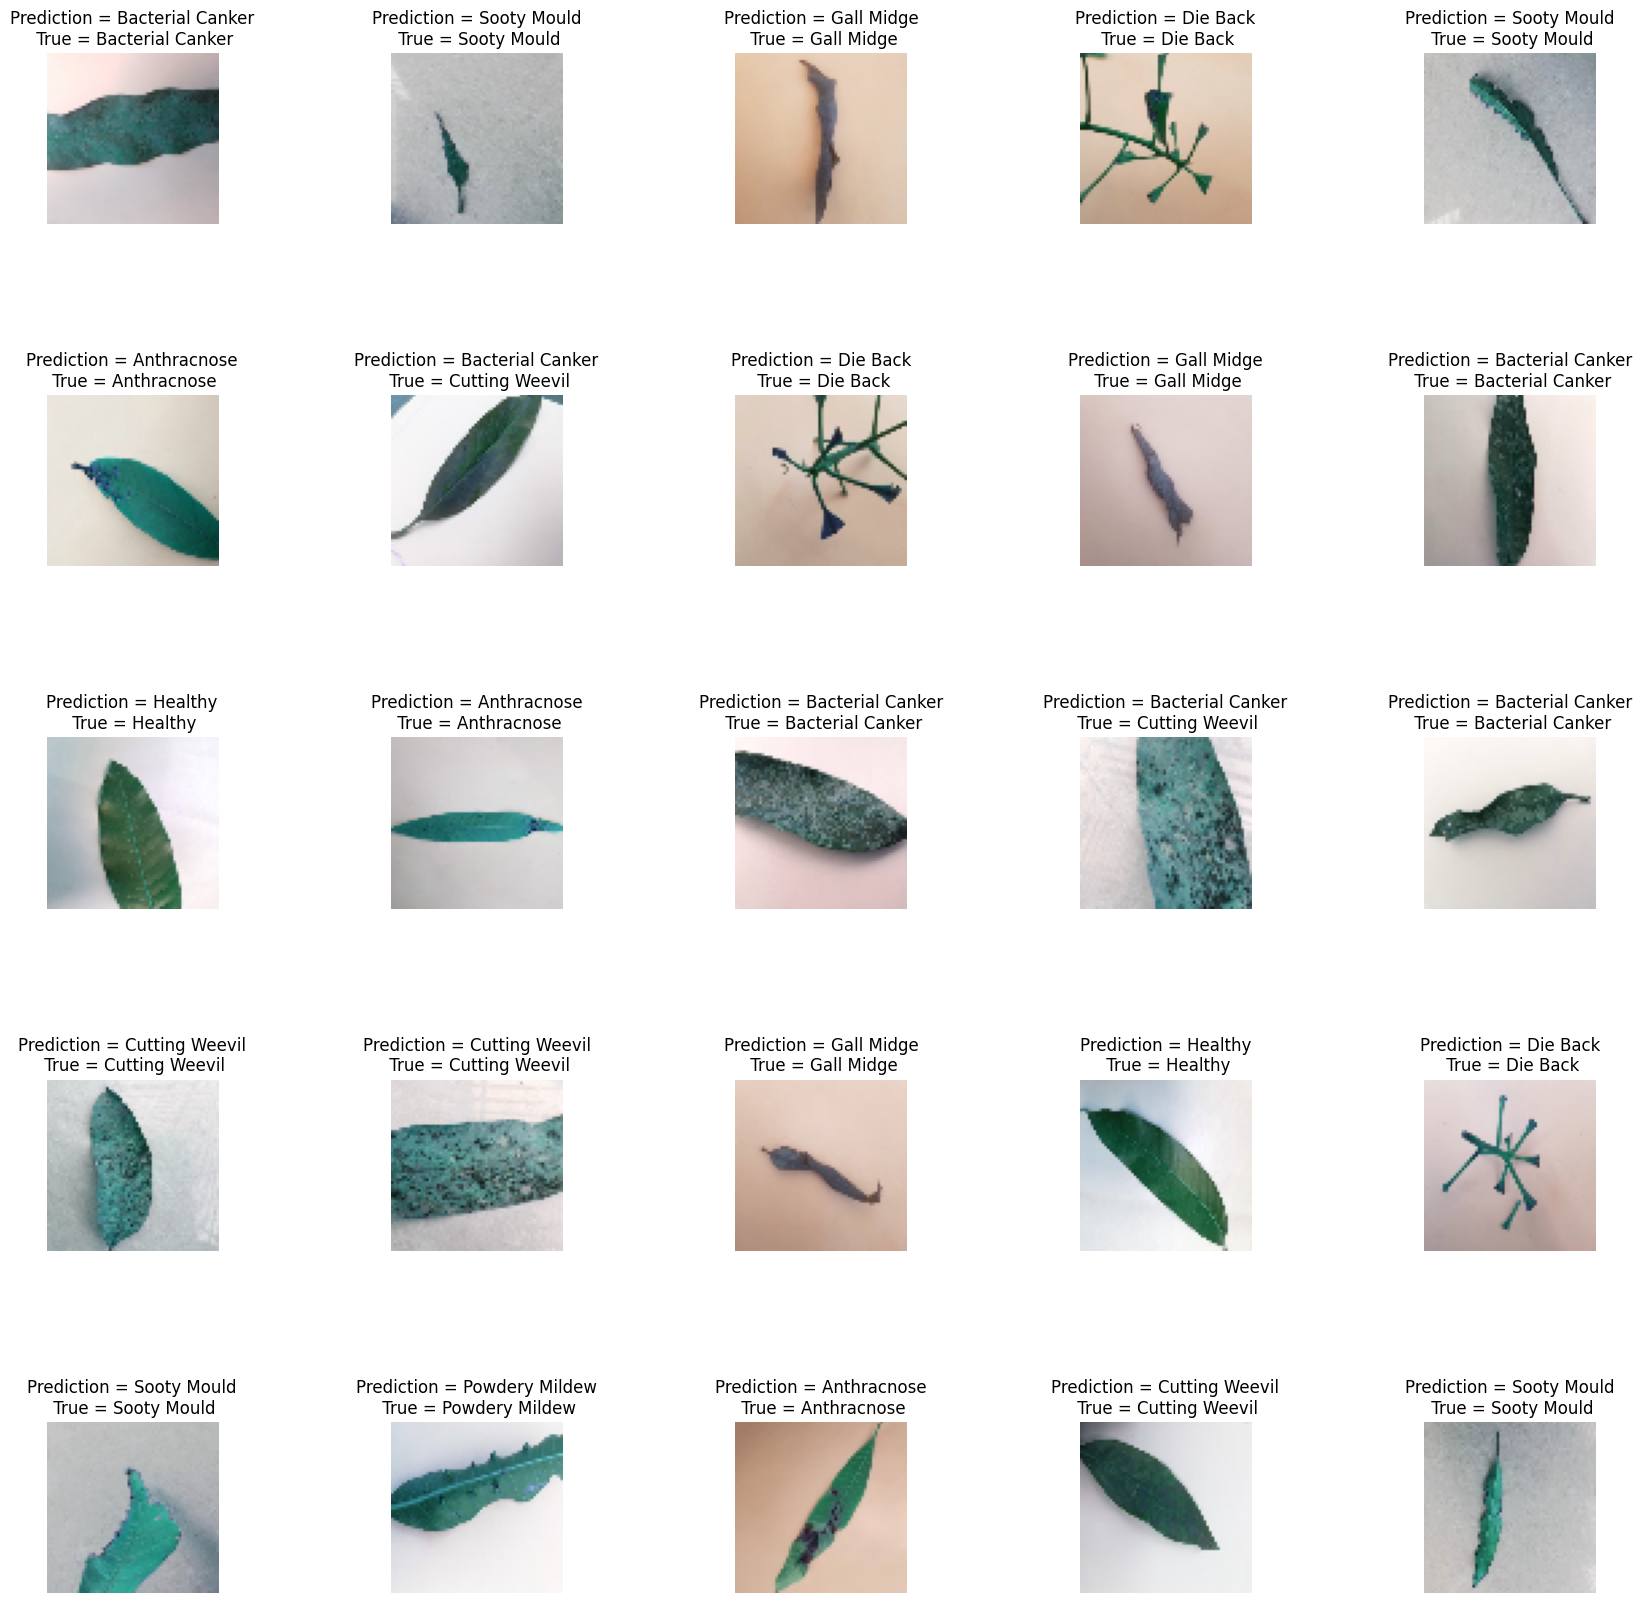

In [19]:
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(20,20))
axes = axes.ravel()
for i in range(5*5):
    number = random.randint(0,len(test_x)-1)
    axes[i].imshow(test_x[number])
    axes[i].set_title(f'Prediction = {names[np.argmax(y_pred[number])]}\n True = {names[np.argmax(test_y[number])]}')
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)   

In [20]:
report = classification_report(test_y_1, y_pred_1, labels=[0,1,2,3,4,5,6,7],target_names=names)
print(report)

                  precision    recall  f1-score   support

     Anthracnose       0.84      0.98      0.91       107
     Sooty Mould       0.93      0.92      0.92        85
        Die Back       0.95      1.00      0.97       110
      Gall Midge       0.96      0.99      0.98       111
  Powdery Mildew       0.88      0.77      0.82       101
         Healthy       0.95      0.97      0.96        90
Bacterial Canker       0.75      0.86      0.80        99
  Cutting Weevil       0.93      0.64      0.76        97

        accuracy                           0.89       800
       macro avg       0.90      0.89      0.89       800
    weighted avg       0.90      0.89      0.89       800



<AxesSubplot: >

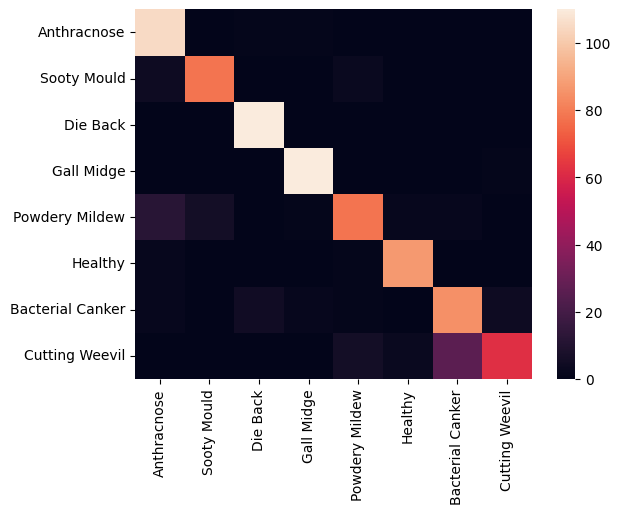

In [21]:
sns.heatmap(confusion_matrix(test_y_1, y_pred_1, labels=[0,1,2,3,4,5,6,7]),xticklabels=names,yticklabels=names)

In [75]:
models_accuracy.append(calculate_accuracy(test_y_1,y_pred_1))
print(f"Accuracy of model 1 is {calculate_accuracy(test_y_1,y_pred_1)*100}%")

Accuracy of model 1 is 89.375%


# Model 2

In [23]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'elu',kernel_initializer = 'he_normal',padding = 'same',input_shape = (64,64,3)))
model.add(Conv2D(32,(3,3),activation = 'elu',kernel_initializer = 'he_normal',padding = 'same',input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(Conv2D(64,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation='elu',kernel_initializer='he_normal'))

model.add(Dense(64,activation='elu',kernel_initializer='he_normal'))

model.add(Dense(num_classes,activation='softmax',kernel_initializer='he_normal'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                  

In [24]:
model_checkpoint = ModelCheckpoint("model2.h5",monitor="val_loss",mode = "min",save_best_only=True,verbose=1)
early_Stopping = EarlyStopping(monitor="val_loss",min_delta=0,patience=8,restore_best_weights=True,verbose=1)
callbacks = [model_checkpoint,early_Stopping]

In [25]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [26]:
history = model.fit(x_train,y_train,epochs=20,validation_data=(val_x,val_y),callbacks=callbacks)

Epoch 1/20
75/75 [==============================] - ETA: 0s - loss: 22.1460 - accuracy: 0.1392
Epoch 1: val_loss improved from inf to 2.10507, saving model to model2.h5
75/75 [==============================] - 4s 21ms/step - loss: 22.1460 - accuracy: 0.1392 - val_loss: 2.1051 - val_accuracy: 0.1325
Epoch 2/20
74/75 [============================>.] - ETA: 0s - loss: 1.9177 - accuracy: 0.2293
Epoch 2: val_loss improved from 2.10507 to 1.64222, saving model to model2.h5
75/75 [==============================] - 1s 18ms/step - loss: 1.9112 - accuracy: 0.2325 - val_loss: 1.6422 - val_accuracy: 0.3225
Epoch 3/20
73/75 [============================>.] - ETA: 0s - loss: 1.4008 - accuracy: 0.4302
Epoch 3: val_loss improved from 1.64222 to 1.18657, saving model to model2.h5
75/75 [==============================] - 1s 17ms/step - loss: 1.3914 - accuracy: 0.4333 - val_loss: 1.1866 - val_accuracy: 0.4762
Epoch 4/20
74/75 [============================>.] - ETA: 0s - loss: 1.0780 - accuracy: 0.5680
Ep

In [27]:
y_pred = model.predict(test_x)
y_pred_2 = [0]*len(y_pred)
test_y_2 = [0]*len(y_pred)
for n,i in enumerate(zip(y_pred,test_y)):
    y_pred_2[n] = np.argmax(y_pred[n])
    test_y_2[n] = np.argmax(test_y[n])

25/25 [==============================] - 0s 4ms/step


In [76]:
models_accuracy.append(calculate_accuracy(test_y_2,y_pred_2))
print(f"Accuracy of model 2 is {calculate_accuracy(test_y_2,y_pred_2)*100}%")

Accuracy of model 2 is 93.5%


<AxesSubplot: >

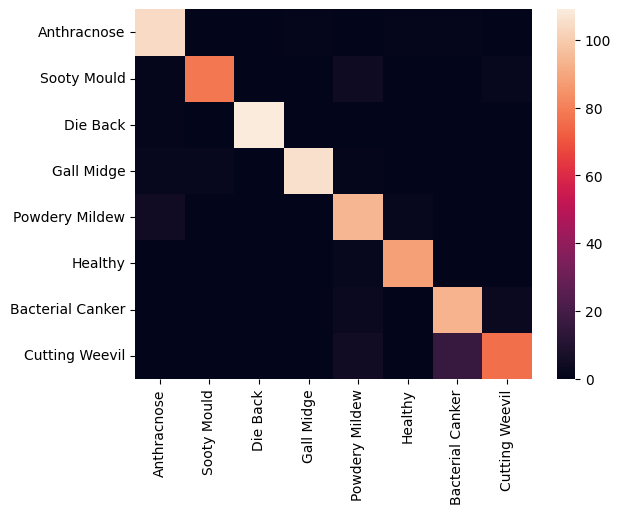

In [29]:
sns.heatmap(confusion_matrix(test_y_2, y_pred_2, labels=[0,1,2,3,4,5,6,7]),xticklabels=names,yticklabels=names)

In [30]:
report = classification_report(test_y_2, y_pred_2, labels=[0,1,2,3,4,5,6,7],target_names=names)
print(report)

                  precision    recall  f1-score   support

     Anthracnose       0.92      0.97      0.95       107
     Sooty Mould       0.97      0.92      0.95        85
        Die Back       1.00      0.99      1.00       110
      Gall Midge       0.99      0.95      0.97       111
  Powdery Mildew       0.86      0.93      0.90       101
         Healthy       0.97      0.98      0.97        90
Bacterial Canker       0.85      0.94      0.89        99
  Cutting Weevil       0.94      0.78      0.85        97

        accuracy                           0.94       800
       macro avg       0.94      0.93      0.93       800
    weighted avg       0.94      0.94      0.93       800



In [31]:
log_model2 = history.history

Text(0.5, 1.0, 'Loss vs Validation Loss')

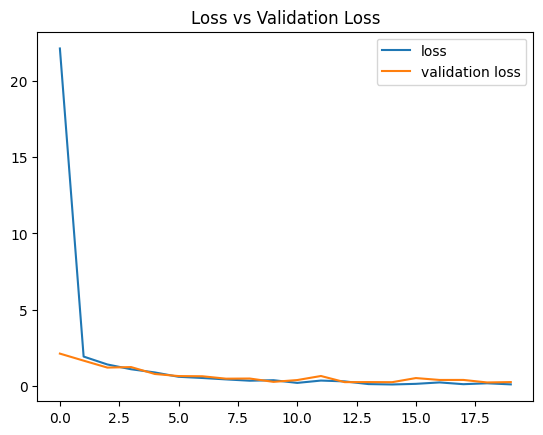

In [32]:
plt.plot(log_model2["loss"],label = "loss")
plt.plot(log_model2["val_loss"],label="validation loss")
plt.legend()
plt.title("Loss vs Validation Loss")

Text(0.5, 1.0, 'Accuracy vs Validation Accuracy')

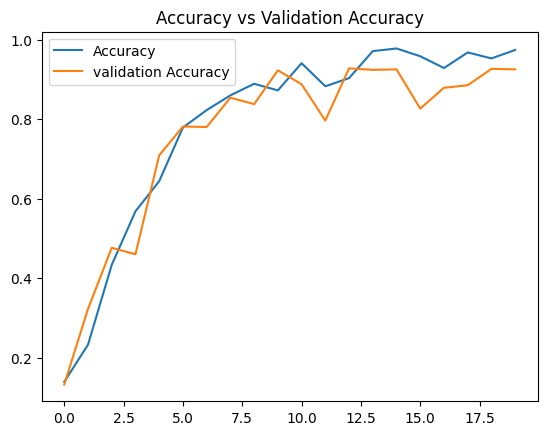

In [33]:
plt.plot(log_model2["accuracy"],label = "Accuracy")
plt.plot(log_model2["val_accuracy"],label="validation Accuracy")
plt.legend()
plt.title("Accuracy vs Validation Accuracy")

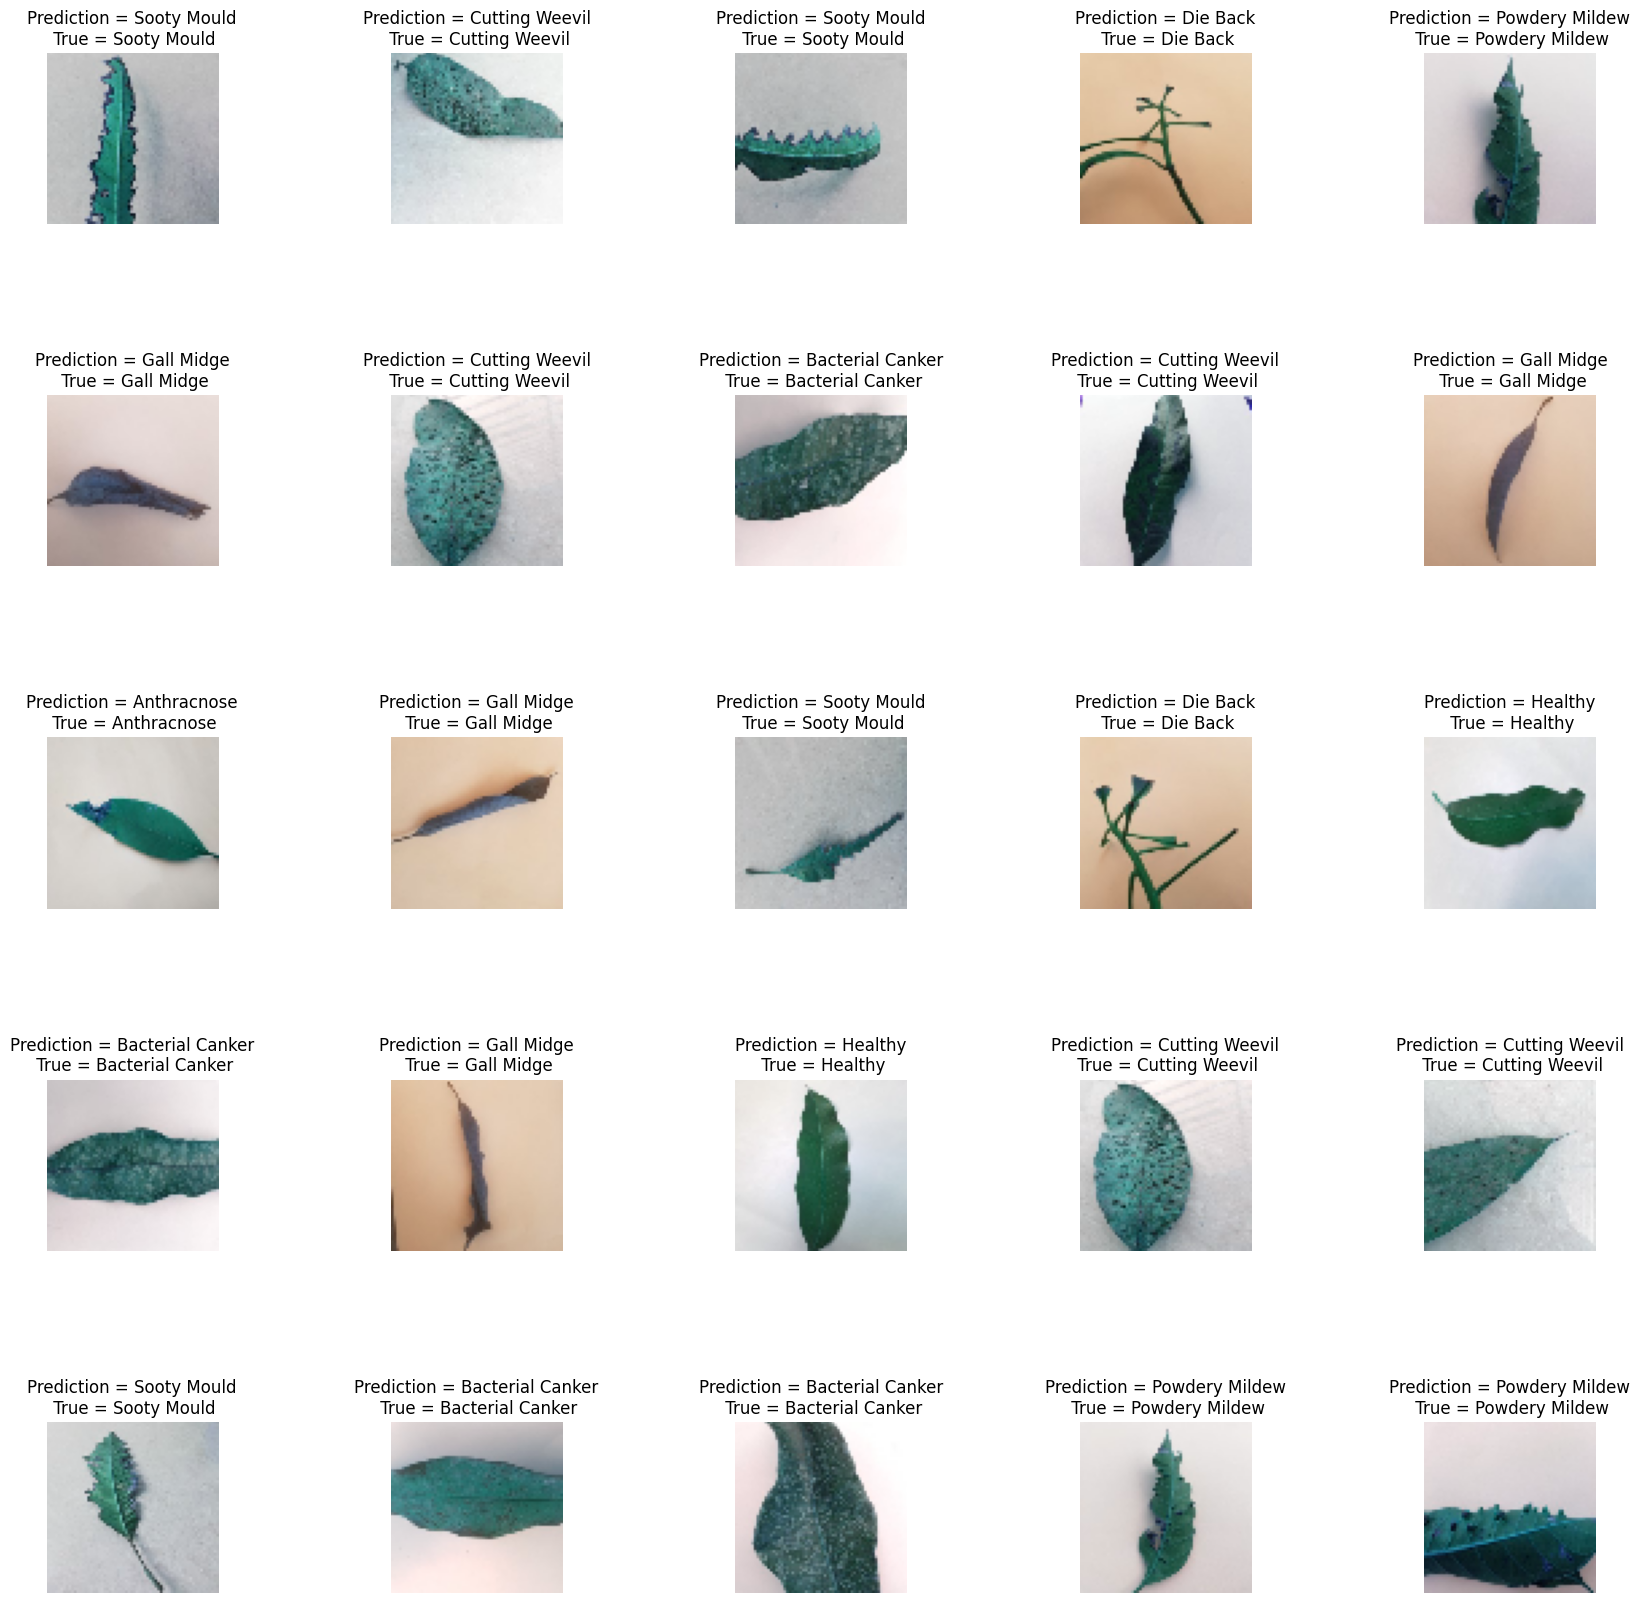

In [35]:
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(20,20))
axes = axes.ravel()
for i in range(5*5):
    number = random.randint(0,len(test_x)-1)
    axes[i].imshow(test_x[number])
    axes[i].set_title(f'Prediction = {names[np.argmax(y_pred[number])]}\n True = {names[np.argmax(test_y[number])]}')
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)   

# Using Transfer Learning

In [36]:

vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_height, img_width, 3))



for layer in vgg16.layers:
    layer.trainable = False
    
    
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [37]:
def addTopModel(bottom_model, num_classes, D=256):
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [38]:
FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs=vgg16.input, outputs=FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [39]:
model_checkpoint = ModelCheckpoint("model_vgg16.h5",monitor="val_loss",mode = "min",save_best_only=True,verbose=1)
early_Stopping = EarlyStopping(monitor="val_loss",min_delta=0,patience=5,restore_best_weights=True,verbose=1)
callbacks = [model_checkpoint,early_Stopping]

In [40]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = SGD(lr=0.001),
              metrics = ['accuracy'])
history = model.fit(x_train,y_train,epochs=25,validation_data=(val_x,val_y),callbacks=callbacks)

Epoch 1/25
73/75 [============================>.] - ETA: 0s - loss: 3.3956 - accuracy: 0.6652
Epoch 1: val_loss improved from inf to 0.59092, saving model to model_vgg16.h5
75/75 [==============================] - 3s 22ms/step - loss: 3.3257 - accuracy: 0.6700 - val_loss: 0.5909 - val_accuracy: 0.8225
Epoch 2/25
73/75 [============================>.] - ETA: 0s - loss: 0.5538 - accuracy: 0.8223
Epoch 2: val_loss improved from 0.59092 to 0.43990, saving model to model_vgg16.h5
75/75 [==============================] - 2s 20ms/step - loss: 0.5511 - accuracy: 0.8225 - val_loss: 0.4399 - val_accuracy: 0.8600
Epoch 3/25
73/75 [============================>.] - ETA: 0s - loss: 0.3898 - accuracy: 0.8746
Epoch 3: val_loss improved from 0.43990 to 0.36220, saving model to model_vgg16.h5
75/75 [==============================] - 2s 21ms/step - loss: 0.3867 - accuracy: 0.8754 - val_loss: 0.3622 - val_accuracy: 0.8838
Epoch 4/25
73/75 [============================>.] - ETA: 0s - loss: 0.3073 - accura

In [41]:
y_pred = model.predict(test_x)
y_pred_3 = [0]*len(y_pred)
test_y_3 = [0]*len(y_pred)
for n,i in enumerate(zip(y_pred,test_y)):
    y_pred_3[n] = np.argmax(y_pred[n])
    test_y_3[n] = np.argmax(test_y[n])

25/25 [==============================] - 0s 13ms/step


In [42]:
log_model3 = history.history

Text(0.5, 1.0, 'Loss vs Validation Loss')

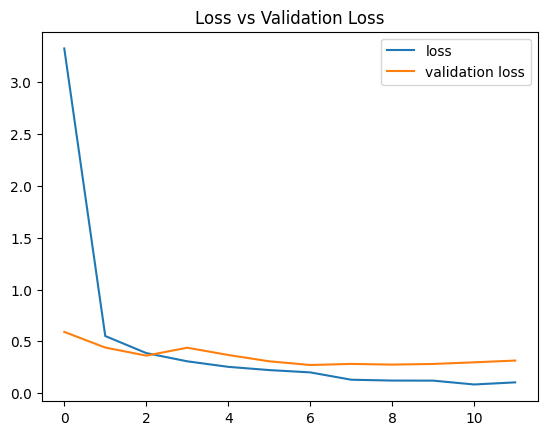

In [43]:
plt.plot(log_model3["loss"],label = "loss")
plt.plot(log_model3["val_loss"],label="validation loss")
plt.legend()
plt.title("Loss vs Validation Loss")

Text(0.5, 1.0, 'Accuracy vs Validation Accuracy')

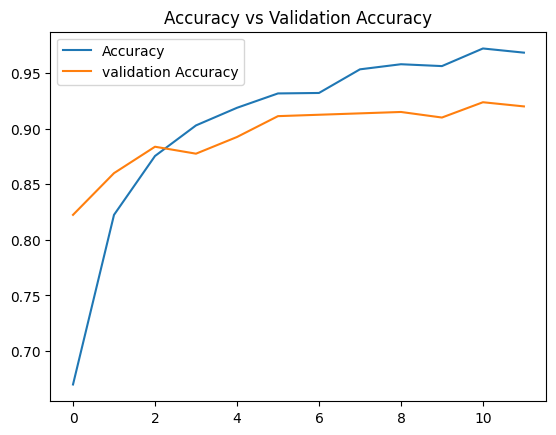

In [44]:
plt.plot(log_model3["accuracy"],label = "Accuracy")
plt.plot(log_model3["val_accuracy"],label="validation Accuracy")
plt.legend()
plt.title("Accuracy vs Validation Accuracy")

In [77]:
models_accuracy.append(calculate_accuracy(test_y_3,y_pred_3))
print(f"Accuracy of model 3 is {calculate_accuracy(test_y_3,y_pred_3)*100}%")

Accuracy of model 3 is 92.25%


In [46]:
report = classification_report(test_y_3, y_pred_3, labels=[0,1,2,3,4,5,6,7],target_names=names)
print(report)

                  precision    recall  f1-score   support

     Anthracnose       0.94      0.94      0.94       107
     Sooty Mould       0.94      0.98      0.96        85
        Die Back       1.00      1.00      1.00       110
      Gall Midge       0.98      1.00      0.99       111
  Powdery Mildew       0.87      0.89      0.88       101
         Healthy       0.87      0.90      0.89        90
Bacterial Canker       0.88      0.83      0.85        99
  Cutting Weevil       0.87      0.82      0.85        97

        accuracy                           0.92       800
       macro avg       0.92      0.92      0.92       800
    weighted avg       0.92      0.92      0.92       800



<AxesSubplot: >

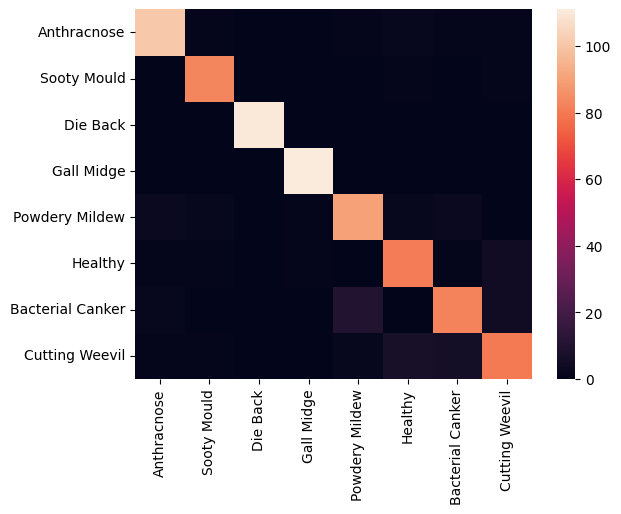

In [47]:
sns.heatmap(confusion_matrix(test_y_3, y_pred_3, labels=[0,1,2,3,4,5,6,7]),xticklabels=names,yticklabels=names)

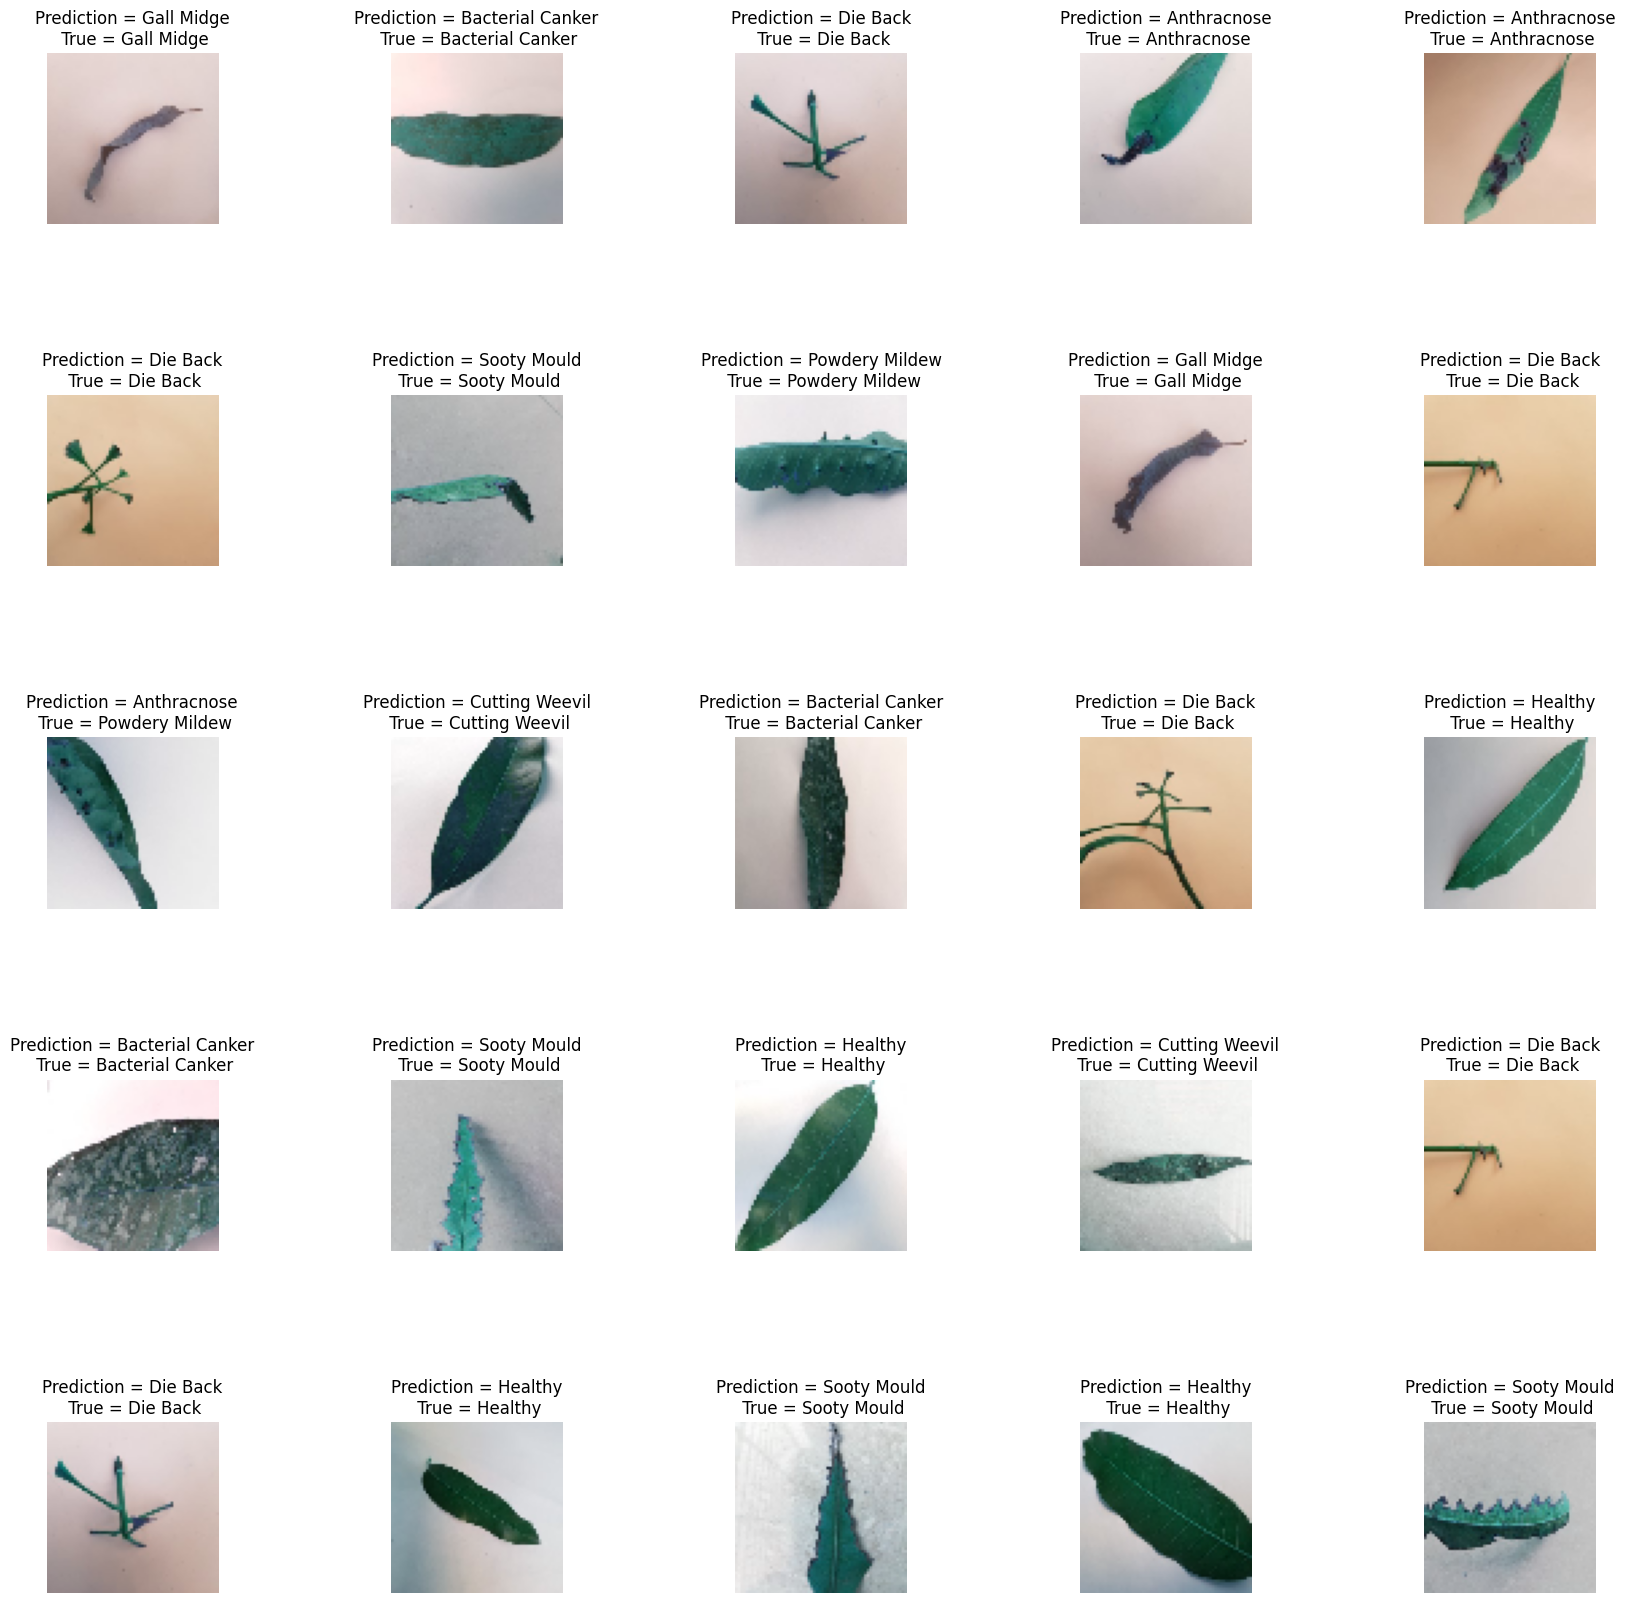

In [48]:
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(20,20))
axes = axes.ravel()
for i in range(5*5):
    number = random.randint(0,len(test_x)-1)
    axes[i].imshow(test_x[number])
    axes[i].set_title(f'Prediction = {names[np.argmax(y_pred[number])]}\n True = {names[np.argmax(test_y[number])]}')
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)   

# Knn Model

In [78]:
knn = KNeighborsClassifier()
knn.fit(x_train.reshape(len(x_train),-1),y_train)
y_pred_knn = knn.predict(test_x.reshape(len(test_x),-1))
print(f"Knn accuracy score is {accuracy_score(test_y,y_pred_knn)*100}%")
models_accuracy.append(accuracy_score(test_y,y_pred_knn))

Knn accuracy score is 57.49999999999999%


# Random Forest Model

In [80]:
rf = RandomForestClassifier()
rf.fit(x_train.reshape(len(x_train),-1),y_train)
y_pred_rf = rf.predict(test_x.reshape(len(test_x),-1))
print(f"Random Forest accuracy score is {accuracy_score(test_y,y_pred_rf)*100}%")
models_accuracy.append(accuracy_score(test_y,y_pred_rf))

Random Forest accuracy score is 63.24999999999999%


# Ploting models accuracy

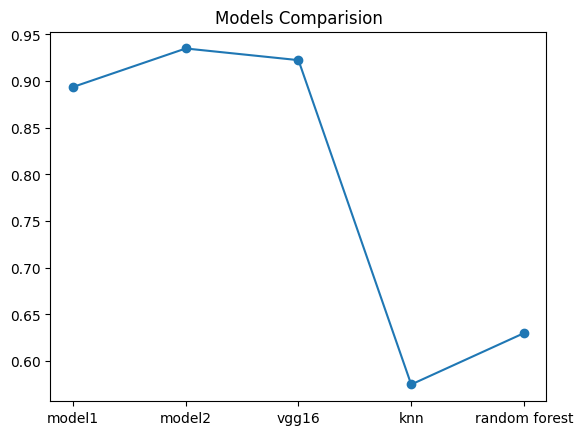

In [83]:
plt.plot(models_accuracy,"o",ls="-")
plt.xticks([0,1,2,3,4],["model1","model2","vgg16","knn","random forest"])
plt.title("Models Comparision")
plt.show()
